## 성능 개선판 word2vec 학습모델 구현

### CBOW 모델 구현

In [1]:
from nn_layers import Embedding, EmbeddingDot, NegativeSamplingLoss,Adam,Trainer
from mynlp import preprocess, most_similar, create_contexts_target
import numpy as np

In [2]:
class CBOW:
    def __init__(self,vocab_size,hidden_size,window_size,corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f')   
        W_out = 0.01*np.random.randn(V,H).astype('f')   # input과 output layer의 W의 shape이 동일
        
        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)       # Embedding 계층 사용
            self.in_layers.append(layer)
            
        self.ns_loss = NegativeSamplingLoss(W_out,corpus,power=0.75,sample_size=5)
        
        # 모든 가중치와 기울기를 리스트에 모은다
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [],[]
        for layer in layers:             
            self.params += layer.params
            self.grads += layer.grads
       
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in   
        
    def forward(self,contexts,target):
        h = 0 
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:,i])  
        
        h *= 1/len(self.in_layers)
        loss = self.ns_loss.forward(h,target)
        return loss
    
    def backward(self,dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1/len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### CBOW 모델 학습 코드

In [3]:
from dataset import ptb
import pickle

# 하이퍼마라미터 설정
window_size = 5

hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
# 전체 데이터 모두 사용시  # 전체 데이터로 epoch 10회 학습 ==> '약 10시간 소요'
corpus, word_to_id, id_to_word = ptb.load_data('train')

vocab_size = len(word_to_id)
print(vocab_size)
print(len(corpus))

10000
929589


In [4]:
# PTB 데이터 중 일부만 사용시
corpus, word_to_id, id_to_word = ptb.load_data('train')

corpus_size = 50000
corpus = corpus[:corpus_size]

vocab_size = int(max(corpus) + 1)

temp1,temp2 = {},{}
for k in range(vocab_size):
    word1= list(word_to_id.keys())[k]    
    id1 = list(word_to_id.values())[k] 
    temp1[word1] = id1
    
    word2= list(id_to_word.keys())[k]    
    id2 = list(id_to_word.values())[k] 
    temp2[word2] = id2
    
word_to_id = temp1
id_to_word =temp2

print(len(corpus))
print(vocab_size)
print(len(word_to_id))
print(len(id_to_word))

50000
5276
5276
5276


| 에폭 1 |  반복 1 / 499 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 499 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 499 | 시간 1[s] | 손실 4.15
| 에폭 1 |  반복 61 / 499 | 시간 2[s] | 손실 4.11
| 에폭 1 |  반복 81 / 499 | 시간 3[s] | 손실 4.01
| 에폭 1 |  반복 101 / 499 | 시간 4[s] | 손실 3.85
| 에폭 1 |  반복 121 / 499 | 시간 5[s] | 손실 3.67
| 에폭 1 |  반복 141 / 499 | 시간 6[s] | 손실 3.49
| 에폭 1 |  반복 161 / 499 | 시간 6[s] | 손실 3.32
| 에폭 1 |  반복 181 / 499 | 시간 7[s] | 손실 3.20
| 에폭 1 |  반복 201 / 499 | 시간 8[s] | 손실 3.09
| 에폭 1 |  반복 221 / 499 | 시간 9[s] | 손실 3.00
| 에폭 1 |  반복 241 / 499 | 시간 10[s] | 손실 2.92
| 에폭 1 |  반복 261 / 499 | 시간 11[s] | 손실 2.87
| 에폭 1 |  반복 281 / 499 | 시간 12[s] | 손실 2.82
| 에폭 1 |  반복 301 / 499 | 시간 13[s] | 손실 2.80
| 에폭 1 |  반복 321 / 499 | 시간 14[s] | 손실 2.77
| 에폭 1 |  반복 341 / 499 | 시간 15[s] | 손실 2.75
| 에폭 1 |  반복 361 / 499 | 시간 16[s] | 손실 2.73
| 에폭 1 |  반복 381 / 499 | 시간 17[s] | 손실 2.71
| 에폭 1 |  반복 401 / 499 | 시간 17[s] | 손실 2.68
| 에폭 1 |  반복 421 / 499 | 시간 18[s] | 손실 2.69
| 에폭 1 |  반복 441 / 499 | 시간 19[s] | 손실 2.71
| 에폭 1

| 에폭 8 |  반복 221 / 499 | 시간 186[s] | 손실 2.36
| 에폭 8 |  반복 241 / 499 | 시간 187[s] | 손실 2.34
| 에폭 8 |  반복 261 / 499 | 시간 188[s] | 손실 2.34
| 에폭 8 |  반복 281 / 499 | 시간 189[s] | 손실 2.36
| 에폭 8 |  반복 301 / 499 | 시간 190[s] | 손실 2.35
| 에폭 8 |  반복 321 / 499 | 시간 191[s] | 손실 2.33
| 에폭 8 |  반복 341 / 499 | 시간 193[s] | 손실 2.36
| 에폭 8 |  반복 361 / 499 | 시간 194[s] | 손실 2.35
| 에폭 8 |  반복 381 / 499 | 시간 195[s] | 손실 2.36
| 에폭 8 |  반복 401 / 499 | 시간 196[s] | 손실 2.36
| 에폭 8 |  반복 421 / 499 | 시간 197[s] | 손실 2.36
| 에폭 8 |  반복 441 / 499 | 시간 198[s] | 손실 2.36
| 에폭 8 |  반복 461 / 499 | 시간 199[s] | 손실 2.35
| 에폭 8 |  반복 481 / 499 | 시간 200[s] | 손실 2.34
| 에폭 9 |  반복 1 / 499 | 시간 201[s] | 손실 2.36
| 에폭 9 |  반복 21 / 499 | 시간 203[s] | 손실 2.28
| 에폭 9 |  반복 41 / 499 | 시간 204[s] | 손실 2.30
| 에폭 9 |  반복 61 / 499 | 시간 205[s] | 손실 2.28
| 에폭 9 |  반복 81 / 499 | 시간 206[s] | 손실 2.28
| 에폭 9 |  반복 101 / 499 | 시간 207[s] | 손실 2.29
| 에폭 9 |  반복 121 / 499 | 시간 208[s] | 손실 2.29
| 에폭 9 |  반복 141 / 499 | 시간 209[s] | 손실 2.28
| 에폭 9 |  반복 161

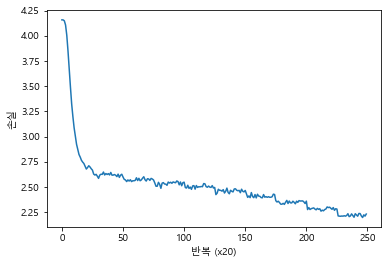

In [5]:
contexts, target = create_contexts_target(corpus,window_size)

# 모델생성
model = CBOW(vocab_size,hidden_size,window_size,corpus)

optimizer = Adam()
trainer = Trainer(model,optimizer)

# 학습 시작
trainer.fit(contexts,target,max_epoch,batch_size)
trainer.plot()

In [7]:
# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl' 
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

###  CBOW 모델 평가

In [11]:
pkl_file = 'cbow_params_epoch10.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
# querys = ['you', 'year', 'car']
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


In [12]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


In [13]:
# 유추(analogy) 작업
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875


### SkipGram 모델 구현

In [14]:
class SkipGram:
    def __init__(self,vocab_size,hidden_size,window_size,corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01*np.random.randn(V,H).astype('f')   
        W_out = 0.01*np.random.randn(V,H).astype('f')   # input과 output layer의 W의 shape이 동일
        
        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out,corpus,power=0.75,sample_size=5)
            self.loss_layers.append(layer)
        
        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [],[]
        for layer in layers:             
            self.params += layer.params
            self.grads += layer.grads
       
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in   
        
    def forward(self,contexts,target):
        h = self.in_layer.forward(target)
        
        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h,contexts[:,i])  
        return loss
    
    def backward(self,dout=1):
        dh = 0
        for layer in self.loss_layers:
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

### SkipGram 모델 학습 코드

In [15]:
from dataset import ptb
import pickle

# 하이퍼파라미터 설정
window_size = 5
# window_size = 2

hidden_size = 100
batch_size = 100
max_epoch = 10  # 10회 이상  , 전체 데이터로 epoch 8회 학습  ==> '7시간 소요'

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')

In [16]:
# PTB 데이터 중 일부만 사용시
corpus, word_to_id, id_to_word = ptb.load_data('train')

corpus_size = 5000
corpus = corpus[:corpus_size]

vocab_size = int(max(corpus) + 1)

temp1,temp2 = {},{}
for k in range(vocab_size):
    word1= list(word_to_id.keys())[k]    
    id1 = list(word_to_id.values())[k] 
    temp1[word1] = id1
    
    word2= list(id_to_word.keys())[k]    
    id2 = list(id_to_word.values())[k] 
    temp2[word2] = id2
    
word_to_id = temp1
id_to_word =temp2

print(len(corpus))
print(vocab_size)
print(len(word_to_id))
print(len(id_to_word))

5000
1326
1326
1326


| 에폭 1 |  반복 1 / 49 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 21 / 49 | 시간 3[s] | 손실 41.57
| 에폭 1 |  반복 41 / 49 | 시간 6[s] | 손실 41.30
| 에폭 2 |  반복 1 / 49 | 시간 7[s] | 손실 40.69
| 에폭 2 |  반복 21 / 49 | 시간 11[s] | 손실 39.40
| 에폭 2 |  반복 41 / 49 | 시간 14[s] | 손실 36.95
| 에폭 3 |  반복 1 / 49 | 시간 15[s] | 손실 35.26
| 에폭 3 |  반복 21 / 49 | 시간 18[s] | 손실 33.37
| 에폭 3 |  반복 41 / 49 | 시간 22[s] | 손실 32.07
| 에폭 4 |  반복 1 / 49 | 시간 23[s] | 손실 31.25
| 에폭 4 |  반복 21 / 49 | 시간 26[s] | 손실 30.27
| 에폭 4 |  반복 41 / 49 | 시간 30[s] | 손실 29.67
| 에폭 5 |  반복 1 / 49 | 시간 31[s] | 손실 29.22
| 에폭 5 |  반복 21 / 49 | 시간 35[s] | 손실 28.71
| 에폭 5 |  반복 41 / 49 | 시간 38[s] | 손실 28.37
| 에폭 6 |  반복 1 / 49 | 시간 40[s] | 손실 28.27
| 에폭 6 |  반복 21 / 49 | 시간 43[s] | 손실 27.79
| 에폭 6 |  반복 41 / 49 | 시간 46[s] | 손실 27.63
| 에폭 7 |  반복 1 / 49 | 시간 48[s] | 손실 27.53
| 에폭 7 |  반복 21 / 49 | 시간 51[s] | 손실 27.24
| 에폭 7 |  반복 41 / 49 | 시간 54[s] | 손실 27.12
| 에폭 8 |  반복 1 / 49 | 시간 55[s] | 손실 27.04
| 에폭 8 |  반복 21 / 49 | 시간 59[s] | 손실 26.80
| 에폭 8 |  반복 41 / 49 | 

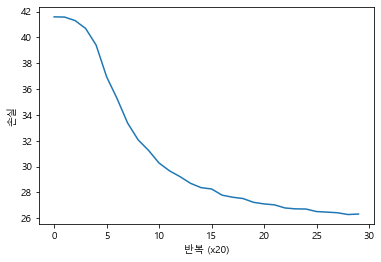

In [17]:
vocab_size = len(word_to_id)


contexts, target = create_contexts_target(corpus, window_size)

# 모델 등 생성
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [18]:
# pkl_file = 'skipgram_params.pkl'
pkl_file = 'skipgram_params_epoch08.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
# querys = ['you', 'year']
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 yourself: 0.693359375
 anybody: 0.666015625
 i: 0.66015625
 somebody: 0.6328125
 your: 0.63134765625

[query] year
 month: 0.60986328125
 earlier: 0.5537109375
 week: 0.5419921875
 quarter: 0.541015625
 fiscal: 0.53759765625

[query] car
 cars: 0.65380859375
 luxury: 0.58203125
 mazda: 0.54638671875
 beretta: 0.52099609375
 truck: 0.51513671875

[query] toyota
 lexus: 0.7197265625
 honda: 0.68359375
 motor: 0.68115234375
 infiniti: 0.6787109375
 mazda: 0.6318359375


In [19]:
# 유추(analogy) 작업
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 teacher: 1.90234375
 incest: 1.8935546875
 hero: 1.736328125
 mystery: 1.736328125
 duck: 1.62109375

[analogy] take:took = go:?
 ran: 1.66796875
 went: 1.5166015625
 walked: 1.4921875
 amsterdam: 1.4775390625
 pricings: 1.41015625

[analogy] car:cars = child:?
 rape: 2.439453125
 adults: 2.2578125
 incest: 1.935546875
 districts: 1.818359375
 children: 1.806640625

[analogy] good:better = bad:?
 ever: 1.5927734375
 vary: 1.4326171875
 comparable: 1.4189453125
 ca: 1.3212890625
 abbie: 1.306640625
